# Assignment: Logistic Regression and Multiclass 
**Environment:** Python, numpy, pandas, matplotlib, seaborn, scikit-learn, ucimlrepo

**Descripción:** Implementación desde cero de regresión logística binaria, One-vs-All (OvA) y Softmax (Multinomial) para clasificación multiclase.  
**Autor(es):** 
  - Chamorro Alva Melvin Jhordan
**Fecha de ejecución:** 16 de octubre de 2025

---

## Contenidos
- [Setup y utilidades](#setup)
- [Parte A — Regresión Logística Binaria desde cero](#parte-a)
  - Derivación matemática del gradiente
  - Implementación from-scratch
  - Evaluación y comparación con sklearn
- [Parte B — Multiclase vía One-vs-All (OvA)](#parte-b)
  - Entrenamiento de K clasificadores binarios
  - Matrices de confusión y métricas
  - Comparación con sklearn
- [Parte C — Multinomial (Softmax) desde cero](#parte-c)
  - Derivación del gradiente multinomial
  - Implementación Softmax Regression
  - Evaluación completa
- [Mini Ensayo y Conclusiones](#ensayo)

---

---
## <a id="setup"></a>Setup y utilidades

En esta sección cargamos las librerías necesarias y definimos funciones auxiliares para preprocesamiento.

In [34]:
# Requisitos (ejecutar solo si hace falta)
# !pip install -q ucimlrepo scikit-learn numpy pandas matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass
from typing import Tuple, List, Optional, Dict

np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid")  # Estilo visual para gráficos

RNG = np.random.default_rng(42)

def train_test_split_index(n: int, train_ratio: float = 0.7, shuffle: bool = True, seed: int = 42):
    """Divide índices en train/test de manera reproducible."""
    idx = np.arange(n)
    if shuffle:
        rng = np.random.default_rng(seed)
        rng.shuffle(idx)
    cut = int(n * train_ratio)
    return idx[:cut], idx[cut:]

def standardize_fit(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Estandariza features (fit): X_std = (X - mu) / sigma."""
    mu = X.mean(axis=0, keepdims=True)
    sigma = X.std(axis=0, ddof=0, keepdims=True)
    sigma[sigma == 0.0] = 1.0  # Evitar división por cero
    return (X - mu) / sigma, mu, sigma

def standardize_transform(X: np.ndarray, mu: np.ndarray, sigma: np.ndarray) -> np.ndarray:
    """Estandariza features (transform): usa mu y sigma previamente calculados."""
    return (X - mu) / sigma

print("Librerías y funciones auxiliares cargadas correctamente")

Librerías y funciones auxiliares cargadas correctamente



---
## <a id="parte-a"></a>Parte A — Regresión Logística **Binaria** desde cero

**Dataset:** _UCI Heart Disease_ (id=45).  
**Tarea:** predecir diagnóstico de enfermedad cardiaca (1) vs. no (0).  
**Preprocesamiento:** estandarizar numéricas, one-hot para categóricas. 70/30 train/test.


In [35]:
# ============================================================
# 1. CARGA DEL DATASET
# ============================================================

from ucimlrepo import fetch_ucirepo

print("="*70)
print("CARGANDO DATASET: UCI HEART DISEASE (ID=45)")
print("="*70)

heart = fetch_ucirepo(id=45)
X_df = heart.data.features.copy()
y_df = heart.data.targets.copy()

print(f"\nDataset cargado:")
print(f"   - Muestras (n): {X_df.shape[0]}")
print(f"   - Features (d): {X_df.shape[1]}")
print(f"   - Target shape: {y_df.shape}")

print(f"\nPrimeras 5 filas del dataset:")
display(X_df.head())

print(f"\nInformación del target (antes de recodificar):")
print(y_df.iloc[:, 0].value_counts().sort_index())

CARGANDO DATASET: UCI HEART DISEASE (ID=45)

Dataset cargado:
   - Muestras (n): 303
   - Features (d): 13
   - Target shape: (303, 1)

Primeras 5 filas del dataset:

Dataset cargado:
   - Muestras (n): 303
   - Features (d): 13
   - Target shape: (303, 1)

Primeras 5 filas del dataset:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0



Información del target (antes de recodificar):
num
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64



### Recode de la variable objetivo
El dataset original puede codificar la presencia de enfermedad con distintos enteros > 0.  
Para binarizar: `y = 0 si y_original == 0`, `1 en caso contrario`.


In [36]:
# ============================================================
# 2. PREPROCESAMIENTO
# ============================================================

print("\n" + "="*70)
print("PREPROCESAMIENTO DE DATOS")
print("="*70)

# --- 2.1 Binarización del target ---
print("\nPaso 1: Binarización del target")
print("   Regla: y=0 si enfermedad=0, y=1 si enfermedad>0")

y_raw = y_df.iloc[:, 0].to_numpy().astype(float)
y = (y_raw != 0).astype(int)

print(f"   Distribución después de binarizar:")
unique, counts = np.unique(y, return_counts=True)
for val, count in zip(unique, counts):
    print(f"      Clase {val}: {count} muestras ({count/len(y)*100:.1f}%)")

# --- 2.2 Identificar columnas numéricas y categóricas ---
print(f"\nPaso 2: Identificar tipos de variables")
num_cols = X_df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = [c for c in X_df.columns if c not in num_cols]

print(f"   - Numéricas ({len(num_cols)}): {num_cols}")
print(f"   - Categóricas ({len(cat_cols)}): {cat_cols}")

# --- 2.3 Imputación de valores faltantes ---
print(f"\nPaso 3: Manejo de valores faltantes")
missing_before = X_df.isnull().sum().sum()
print(f"   Valores faltantes antes: {missing_before}")

# Numéricas: imputar con mediana
for c in num_cols:
    if X_df[c].isnull().sum() > 0:
        median_val = X_df[c].median()
        X_df[c] = X_df[c].fillna(median_val)
        print(f"   - '{c}': imputado con mediana = {median_val:.2f}")

# Categóricas: imputar con categoría "missing"
for c in cat_cols:
    if X_df[c].isnull().sum() > 0:
        X_df[c] = X_df[c].astype('category')
        X_df[c] = X_df[c].cat.add_categories("missing").fillna("missing")
        print(f"   - '{c}': imputado con categoría 'missing'")

missing_after = X_df.isnull().sum().sum()
print(f"   Valores faltantes después: {missing_after}")

# --- 2.4 One-Hot Encoding ---
print(f"\nPaso 4: One-Hot Encoding de variables categóricas")
X_dummies = pd.get_dummies(X_df, columns=cat_cols, drop_first=True)
print(f"   Shape después de One-Hot: {X_dummies.shape}")
print(f"   Nuevas columnas creadas: {X_dummies.shape[1] - len(num_cols)}")

feature_names = X_dummies.columns.tolist()

# --- 2.5 Split Train/Test 70/30 ---
print(f"\nPaso 5: Split Train/Test (70/30)")
idx_tr, idx_te = train_test_split_index(len(X_dummies), train_ratio=0.7, seed=42)
X_tr_df = X_dummies.iloc[idx_tr].reset_index(drop=True)
X_te_df = X_dummies.iloc[idx_te].reset_index(drop=True)
y_tr = y[idx_tr]
y_te = y[idx_te]

print(f"   Train: {len(y_tr)} muestras")
print(f"   Test:  {len(y_te)} muestras")

# --- 2.6 Estandarización (solo numéricas) ---
print(f"\nPaso 6: Estandarización de variables numéricas")
print(f"   (Solo se estandarizan las {len(num_cols)} variables numéricas originales)")

num_mask = np.array([name in num_cols for name in feature_names], dtype=bool)
X_tr = X_tr_df.to_numpy().astype(float)
X_te = X_te_df.to_numpy().astype(float)

# Estandarizar solo las columnas numéricas
X_tr_num, mu, sigma = standardize_fit(X_tr[:, num_mask])
X_te_num = standardize_transform(X_te[:, num_mask], mu, sigma)

X_tr[:, num_mask] = X_tr_num
X_te[:, num_mask] = X_te_num

print(f"   Estandarización completada")
print(f"   Shape final - Train: {X_tr.shape}, Test: {X_te.shape}")

print("\n" + "="*70)
print("PREPROCESAMIENTO COMPLETADO")
print("="*70)


PREPROCESAMIENTO DE DATOS

Paso 1: Binarización del target
   Regla: y=0 si enfermedad=0, y=1 si enfermedad>0
   Distribución después de binarizar:
      Clase 0: 164 muestras (54.1%)
      Clase 1: 139 muestras (45.9%)

Paso 2: Identificar tipos de variables
   - Numéricas (13): ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
   - Categóricas (0): []

Paso 3: Manejo de valores faltantes
   Valores faltantes antes: 6
   - 'ca': imputado con mediana = 0.00
   - 'thal': imputado con mediana = 3.00
   Valores faltantes después: 0

Paso 4: One-Hot Encoding de variables categóricas
   Shape después de One-Hot: (303, 13)
   Nuevas columnas creadas: 0

Paso 5: Split Train/Test (70/30)
   Train: 212 muestras
   Test:  91 muestras

Paso 6: Estandarización de variables numéricas
   (Solo se estandarizan las 13 variables numéricas originales)
   Estandarización completada
   Shape final - Train: (212, 13), Test: (91, 13)

PREPROCES


### Derivación (resumen) — Gradiente de la **log-verosimilitud** binaria

Modelo: \\( \sigma(z) = \frac{1}{1 + e^{-z}} \\), con \\( z = Xw \\).  
Log-verosimilitud: \\( \ell(w) = \sum_{i=1}^n \big[y_i \log p_i + (1-y_i)\log(1-p_i)\big] \\), donde \\( p_i = \sigma(x_i^T w) \\).  
Gradiente: \\( \nabla \ell(w) = X^T (y - p) \\).  
Para **minimizar** la pérdida NLL: \\( J(w) = -\ell(w) \\) ⇒ \\( \nabla J(w) = X^T (p - y) \\).


### 📐 Derivación matemática del gradiente (paso a paso)

**Modelo:**  
La regresión logística binaria modela la probabilidad de la clase positiva (y=1) mediante la función sigmoide:

$$
p(x) = \sigma(z) = \frac{1}{1 + e^{-z}}, \quad \text{donde } z = w^T x
$$

**Función de pérdida (Negative Log-Likelihood):**  
Para una observación $(x^{(i)}, y^{(i)})$:

$$
J(w) = -\frac{1}{n}\sum_{i=1}^n \left[ y^{(i)} \log(p^{(i)}) + (1-y^{(i)}) \log(1-p^{(i)}) \right]
$$

donde $p^{(i)} = \sigma(w^T x^{(i)})$.

**Derivación del gradiente:**

1. **Derivada de la sigmoide:**  
   $$\frac{d\sigma(z)}{dz} = \sigma(z)(1-\sigma(z))$$

2. **Gradiente para una observación:**  
   Aplicando la regla de la cadena:
   $$
   \frac{\partial J}{\partial w} = \frac{\partial J}{\partial p} \cdot \frac{\partial p}{\partial z} \cdot \frac{\partial z}{\partial w}
   $$

3. **Calculamos cada término:**
   - $\frac{\partial J}{\partial p} = -\frac{y}{p} + \frac{1-y}{1-p}$
   - $\frac{\partial p}{\partial z} = p(1-p)$
   - $\frac{\partial z}{\partial w} = x$

4. **Simplificando:**
   $$
   \frac{\partial J}{\partial w} = \left(-\frac{y}{p} + \frac{1-y}{1-p}\right) \cdot p(1-p) \cdot x = (p - y) \cdot x
   $$

5. **Para todas las observaciones (forma matricial):**
   $$
   \boxed{\nabla_w J = \frac{1}{n} X^T (p - y)}
   $$

donde $X \in \mathbb{R}^{n \times d}$, $p \in \mathbb{R}^{n}$ (predicciones), $y \in \mathbb{R}^{n}$ (etiquetas reales).

**Actualización de pesos (Gradient Descent):**
$$
w^{(t+1)} = w^{(t)} - \alpha \nabla_w J
$$

donde $\alpha$ es la tasa de aprendizaje (learning rate).

In [37]:

@dataclass
class LogisticRegressionScratch:
    lr: float = 0.1
    n_iter: int = 2000
    fit_intercept: bool = True
    l2: float = 0.0
    history_: Dict[str, List[float]] = None
    w_: Optional[np.ndarray] = None

    @staticmethod
    def _sigmoid(z: np.ndarray) -> np.ndarray:
        # estabilidad numérica
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    def _add_intercept(self, X: np.ndarray) -> np.ndarray:
        if not self.fit_intercept:
            return X
        return np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

    def fit(self, X: np.ndarray, y: np.ndarray, verbose: bool = False):
        Xb = self._add_intercept(X)
        n, d = Xb.shape
        self.w_ = np.zeros(d)
        self.history_ = {"loss": []}

        for t in range(self.n_iter):
            z = Xb @ self.w_
            p = self._sigmoid(z)
            # pérdida NLL + L2
            loss = -(y*np.log(p+1e-12) + (1-y)*np.log(1-p+1e-12)).mean() + 0.5*self.l2*np.sum(self.w_[1:]**2)/n
            self.history_["loss"].append(loss)

            # gradiente
            grad = (Xb.T @ (p - y)) / n
            if self.l2 > 0:
                grad[1:] += self.l2 * self.w_[1:] / n

            self.w_ -= self.lr * grad

        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        Xb = self._add_intercept(X)
        return self._sigmoid(Xb @ self.w_)

    def predict(self, X: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        return (self.predict_proba(X) >= threshold).astype(int)


### Entrenamiento y curvas de convergencia (dos tasas de aprendizaje)

=== Entrenando modelos con diferentes learning rates ===

Modelo con lr=0.05 entrenado (1500 iteraciones)
Modelo con lr=0.5 entrenado (1500 iteraciones)
Modelo con lr=0.5 entrenado (1500 iteraciones)


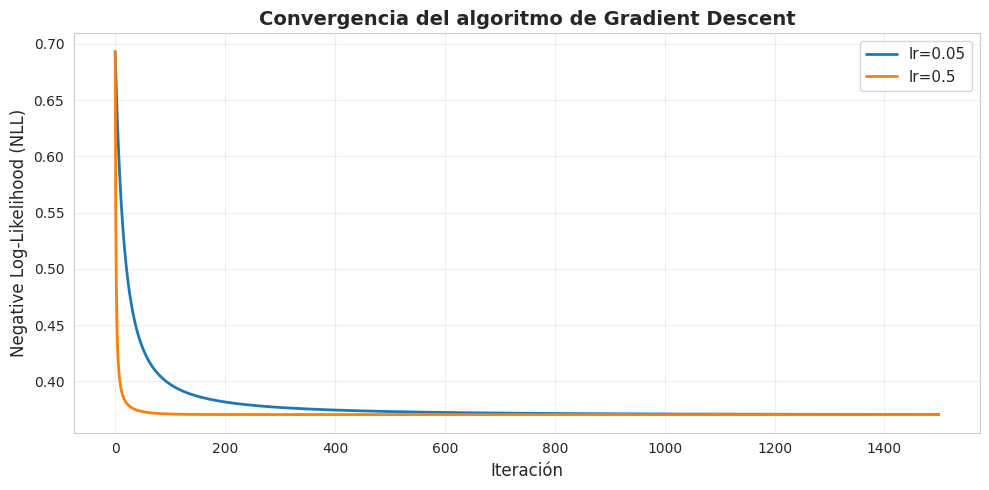


EVALUACIÓN EN TEST SET - REGRESIÓN LOGÍSTICA BINARIA (FROM SCRATCH)

Métricas del modelo (lr=0.05):
   Accuracy:  0.8901 (89.01%)
   Precision: 0.9444
   Recall:    0.8095
   F1-Score:  0.8718

Classification Report:
                precision    recall  f1-score   support

No Disease (0)       0.85      0.96      0.90        49
   Disease (1)       0.94      0.81      0.87        42

      accuracy                           0.89        91
     macro avg       0.90      0.88      0.89        91
  weighted avg       0.90      0.89      0.89        91



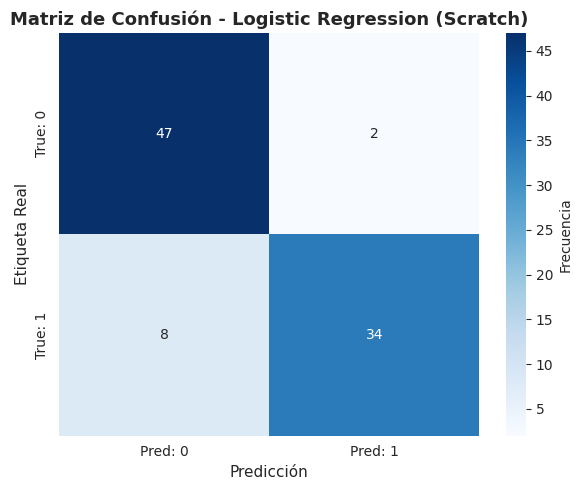

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

# Entrenar con dos tasas de aprendizaje
rates = [0.05, 0.5]
models = []

print("=== Entrenando modelos con diferentes learning rates ===\n")
for lr in rates:
    clf = LogisticRegressionScratch(lr=lr, n_iter=1500, l2=0.0).fit(X_tr, y_tr)
    models.append(clf)
    print(f"Modelo con lr={lr} entrenado ({len(clf.history_['loss'])} iteraciones)")

# Gráfico de convergencia
plt.figure(figsize=(10,5))
for lr, clf in zip(rates, models):
    plt.plot(clf.history_["loss"], label=f"lr={lr}", linewidth=2)
plt.xlabel("Iteración", fontsize=12)
plt.ylabel("Negative Log-Likelihood (NLL)", fontsize=12)
plt.title("Convergencia del algoritmo de Gradient Descent", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("EVALUACIÓN EN TEST SET - REGRESIÓN LOGÍSTICA BINARIA (FROM SCRATCH)")
print("="*70)

# Usar el modelo con lr=0.05 (mejor convergencia)
model_final = models[0]
y_pred_scratch = model_final.predict(X_te)
y_pred_proba_scratch = model_final.predict_proba(X_te)

# Métricas
acc_scratch = accuracy_score(y_te, y_pred_scratch)
prec_scratch = precision_score(y_te, y_pred_scratch, zero_division=0)
rec_scratch = recall_score(y_te, y_pred_scratch, zero_division=0)
f1_scratch = f1_score(y_te, y_pred_scratch, zero_division=0)

print(f"\nMétricas del modelo (lr={rates[0]}):")
print(f"   Accuracy:  {acc_scratch:.4f} ({acc_scratch*100:.2f}%)")
print(f"   Precision: {prec_scratch:.4f}")
print(f"   Recall:    {rec_scratch:.4f}")
print(f"   F1-Score:  {f1_scratch:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_te, y_pred_scratch, target_names=['No Disease (0)', 'Disease (1)'], zero_division=0))

# Matriz de confusión
cm_scratch = confusion_matrix(y_te, y_pred_scratch)
plt.figure(figsize=(6,5))
sns.heatmap(cm_scratch, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: 0', 'Pred: 1'],
            yticklabels=['True: 0', 'True: 1'],
            cbar_kws={'label': 'Frecuencia'})
plt.title('Matriz de Confusión - Logistic Regression (Scratch)', fontsize=13, fontweight='bold')
plt.ylabel('Etiqueta Real', fontsize=11)
plt.xlabel('Predicción', fontsize=11)
plt.tight_layout()
plt.show()

In [39]:
from sklearn.linear_model import LogisticRegression

print("="*70)
print("COMPARACIÓN CON SKLEARN")
print("="*70)

# Entrenar modelo sklearn
sk_bin = LogisticRegression(max_iter=5000, solver='lbfgs', random_state=42)
sk_bin.fit(X_tr, y_tr)
y_pred_sk = sk_bin.predict(X_te)

# Métricas sklearn
acc_sk = accuracy_score(y_te, y_pred_sk)
prec_sk = precision_score(y_te, y_pred_sk, zero_division=0)
rec_sk = recall_score(y_te, y_pred_sk, zero_division=0)
f1_sk = f1_score(y_te, y_pred_sk, zero_division=0)

print(f"\nMétricas sklearn:")
print(f"   Accuracy:  {acc_sk:.4f} ({acc_sk*100:.2f}%)")
print(f"   Precision: {prec_sk:.4f}")
print(f"   Recall:    {rec_sk:.4f}")
print(f"   F1-Score:  {f1_sk:.4f}")

# Comparación lado a lado
print(f"\nComparación From-Scratch vs. Sklearn:")
print(f"{'Métrica':<15} {'From-Scratch':<15} {'Sklearn':<15} {'Diferencia':<15}")
print("-" * 60)
print(f"{'Accuracy':<15} {acc_scratch:<15.4f} {acc_sk:<15.4f} {abs(acc_scratch-acc_sk):<15.4f}")
print(f"{'Precision':<15} {prec_scratch:<15.4f} {prec_sk:<15.4f} {abs(prec_scratch-prec_sk):<15.4f}")
print(f"{'Recall':<15} {rec_scratch:<15.4f} {rec_sk:<15.4f} {abs(rec_scratch-rec_sk):<15.4f}")
print(f"{'F1-Score':<15} {f1_scratch:<15.4f} {f1_sk:<15.4f} {abs(f1_scratch-f1_sk):<15.4f}")

print(f"\nConclusión: Ambos modelos tienen rendimiento {'similar' if abs(acc_scratch - acc_sk) < 0.05 else 'diferente'}")
print(f"(Diferencia en accuracy: {abs(acc_scratch - acc_sk)*100:.2f}%)\n")

COMPARACIÓN CON SKLEARN

Métricas sklearn:
   Accuracy:  0.8901 (89.01%)
   Precision: 0.9444
   Recall:    0.8095
   F1-Score:  0.8718

Comparación From-Scratch vs. Sklearn:
Métrica         From-Scratch    Sklearn         Diferencia     
------------------------------------------------------------
Accuracy        0.8901          0.8901          0.0000         
Precision       0.9444          0.9444          0.0000         
Recall          0.8095          0.8095          0.0000         
F1-Score        0.8718          0.8718          0.0000         

Conclusión: Ambos modelos tienen rendimiento similar
(Diferencia en accuracy: 0.00%)




---
## <a id="parte-b"></a>Parte B — Multiclase **One-vs-All (OvA)**

**Dataset:** `sklearn.datasets.load_wine` (3 clases, 13 features).  
**Estrategia:** entrenar 3 clasificadores binarios usando el optimizador de la Parte A y predecir con `argmax` de probabilidades.


PARTE B: ONE-VS-ALL (OvA) - DATASET WINE

Dataset cargado:
   Clases: 3 (cultivares de vino)
   Features: 13 (características químicas)
   Muestras: 178
   Nombres de clases: ['class_0' 'class_1' 'class_2']

Split 70/30:
   Train: 124 muestras
   Test:  54 muestras

Entrenando 3 clasificadores binarios (One-vs-All)...
   Clasificador 0 (class_0) entrenado
   Clasificador 1 (class_1) entrenado
   Clasificador 1 (class_1) entrenado
   Clasificador 2 (class_2) entrenado

Realizando predicciones (argmax de probabilidades)...

Accuracy (OvA from scratch): 1.0000 (100.00%)

Classification Report (OvA):
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        24
     class_1       1.00      1.00      1.00        14
     class_2       1.00      1.00      1.00        16

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54

   Clasificador

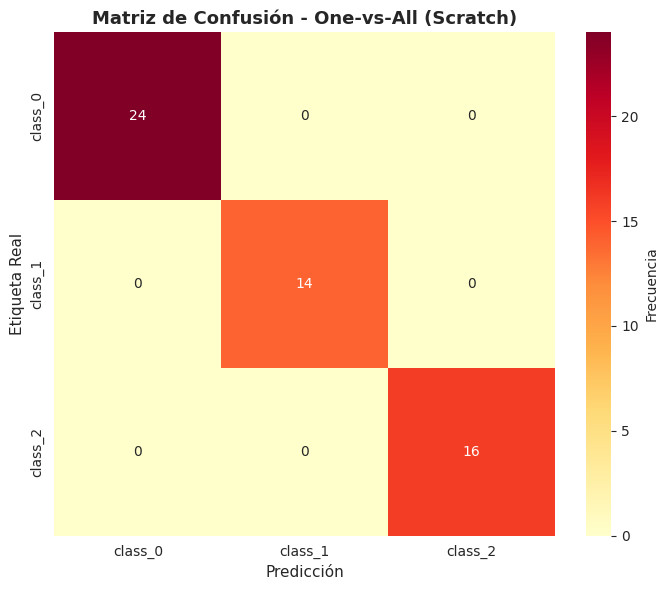

In [40]:
from sklearn.datasets import load_wine
from sklearn.metrics import confusion_matrix, classification_report

print("="*70)
print("PARTE B: ONE-VS-ALL (OvA) - DATASET WINE")
print("="*70)

# Cargar dataset Wine
wine = load_wine(as_frame=True)
Xw_df = wine.data.copy()
yw = wine.target.to_numpy()

print(f"\nDataset cargado:")
print(f"   Clases: {len(np.unique(yw))} (cultivares de vino)")
print(f"   Features: {Xw_df.shape[1]} (características químicas)")
print(f"   Muestras: {Xw_df.shape[0]}")
print(f"   Nombres de clases: {wine.target_names}")

# Estandarización total
Xw, mu_w, sigma_w = standardize_fit(Xw_df.to_numpy().astype(float))

# Split 70/30
idx_tr_w, idx_te_w = train_test_split_index(len(Xw), train_ratio=0.7, seed=42)
Xw_tr, Xw_te = Xw[idx_tr_w], Xw[idx_te_w]
yw_tr, yw_te = yw[idx_tr_w], yw[idx_te_w]

print(f"\nSplit 70/30:")
print(f"   Train: {len(yw_tr)} muestras")
print(f"   Test:  {len(yw_te)} muestras")

# Entrenar K clasificadores binarios (OvA)
K = len(np.unique(yw))
ovr_models = []

print(f"\nEntrenando {K} clasificadores binarios (One-vs-All)...")
for k in range(K):
    yk_tr = (yw_tr == k).astype(int)  # Binarizar: clase k vs resto
    clf_k = LogisticRegressionScratch(lr=0.2, n_iter=2000, l2=0.0).fit(Xw_tr, yk_tr)
    ovr_models.append(clf_k)
    print(f"   Clasificador {k} ({wine.target_names[k]}) entrenado")

# Predicción OvA: argmax de probabilidades
print(f"\nRealizando predicciones (argmax de probabilidades)...")
P = np.column_stack([m.predict_proba(Xw_te) for m in ovr_models])
y_pred_ova = P.argmax(axis=1)

# Métricas
acc_ova = accuracy_score(yw_te, y_pred_ova)
print(f"\nAccuracy (OvA from scratch): {acc_ova:.4f} ({acc_ova*100:.2f}%)")

# Classification Report
print(f"\nClassification Report (OvA):")
print(classification_report(yw_te, y_pred_ova, 
                          target_names=wine.target_names, 
                          zero_division=0))

# Matriz de confusión
cm_ova = confusion_matrix(yw_te, y_pred_ova)
plt.figure(figsize=(7,6))
sns.heatmap(cm_ova, annot=True, fmt='d', cmap='YlOrRd', 
            xticklabels=wine.target_names,
            yticklabels=wine.target_names,
            cbar_kws={'label': 'Frecuencia'})
plt.title('Matriz de Confusión - One-vs-All (Scratch)', fontsize=13, fontweight='bold')
plt.ylabel('Etiqueta Real', fontsize=11)
plt.xlabel('Predicción', fontsize=11)
plt.tight_layout()
plt.show()

COMPARACIÓN CON SKLEARN (OvA)

Accuracy (sklearn OvR): 1.0000 (100.00%)

Classification Report (sklearn):
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        24
     class_1       1.00      1.00      1.00        14
     class_2       1.00      1.00      1.00        16

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54


Comparación de dimensiones de coeficientes:
   From-Scratch: 3 modelos, cada uno con shape (14,)
   Sklearn:      coef_ shape = (3, 13)

Comparación de Accuracy:
   From-Scratch (OvA): 1.0000
   Sklearn (OvR):      1.0000
   Diferencia:         0.0000


/home/dedostorcidos/Documentos/TAREAS/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


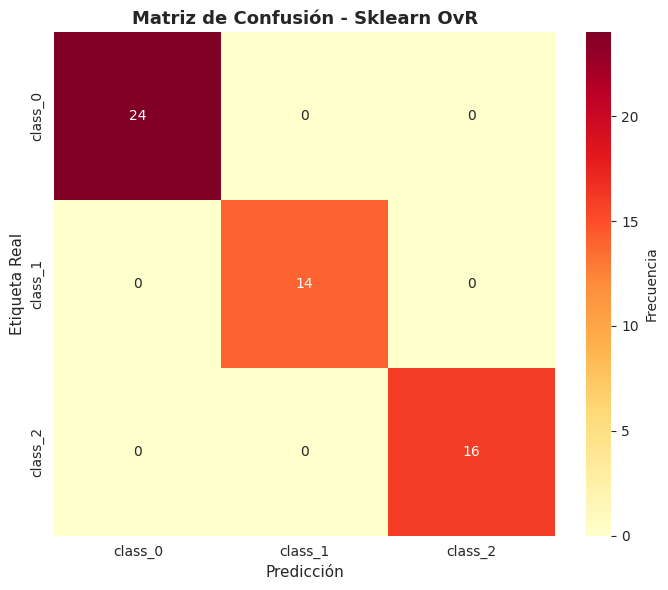


Conclusión: Ambos modelos tienen rendimiento muy similar



In [41]:
print("="*70)
print("COMPARACIÓN CON SKLEARN (OvA)")
print("="*70)

# Comparación con sklearn OvR
sk_ova = LogisticRegression(max_iter=5000, multi_class="ovr", solver='lbfgs', random_state=42)
sk_ova.fit(Xw_tr, yw_tr)
y_pred_sk_ovr = sk_ova.predict(Xw_te)

acc_sk_ovr = accuracy_score(yw_te, y_pred_sk_ovr)
print(f"\nAccuracy (sklearn OvR): {acc_sk_ovr:.4f} ({acc_sk_ovr*100:.2f}%)")

print(f"\nClassification Report (sklearn):")
print(classification_report(yw_te, y_pred_sk_ovr, 
                          target_names=wine.target_names, 
                          zero_division=0))

# Comparación de coeficientes
print(f"\nComparación de dimensiones de coeficientes:")
print(f"   From-Scratch: {K} modelos, cada uno con shape {ovr_models[0].w_.shape}")
print(f"   Sklearn:      coef_ shape = {sk_ova.coef_.shape}")

print(f"\nComparación de Accuracy:")
print(f"   From-Scratch (OvA): {acc_ova:.4f}")
print(f"   Sklearn (OvR):      {acc_sk_ovr:.4f}")
print(f"   Diferencia:         {abs(acc_ova - acc_sk_ovr):.4f}")

# Matriz de confusión sklearn
cm_sk_ovr = confusion_matrix(yw_te, y_pred_sk_ovr)
plt.figure(figsize=(7,6))
sns.heatmap(cm_sk_ovr, annot=True, fmt='d', cmap='YlOrRd', 
            xticklabels=wine.target_names,
            yticklabels=wine.target_names,
            cbar_kws={'label': 'Frecuencia'})
plt.title('Matriz de Confusión - Sklearn OvR', fontsize=13, fontweight='bold')
plt.ylabel('Etiqueta Real', fontsize=11)
plt.xlabel('Predicción', fontsize=11)
plt.tight_layout()
plt.show()

print(f"\nConclusión: Ambos modelos tienen rendimiento {'muy similar' if abs(acc_ova - acc_sk_ovr) < 0.02 else 'comparable'}\n")


---
## <a id="parte-c"></a>Parte C — Regresión Logística **Multinomial (Softmax)** desde cero

**Teoría (resumen):**  
Sea \\( W \\in \\mathbb{R}^{d \\times K} \\) y \\( Z = XW \\). La probabilidad para clase \\(k\\):  
\\[ p_{ik} = \\frac{\\exp(z_{ik})}{\\sum_{j=1}^K \\exp(z_{ij})} \\]  
Log-verosimilitud: \\( \\ell(W) = \\sum_i \\sum_k y_{ik} \\log p_{ik} \\).  
Gradiente: \\( \\nabla_W \\ell = X^T (Y - P) \\) y para minimizar la pérdida (NLL): \\( \\nabla_W J = X^T (P - Y) \\).  
**Estabilidad numérica:** restar `z.max(axis=1, keepdims=True)` antes del `exp`.


### 📐 Derivación matemática del gradiente Multinomial (Softmax)

**Modelo Softmax:**  
Para $K$ clases, el modelo softmax calcula la probabilidad de cada clase $k$ como:

$$
p_{ik} = P(y^{(i)} = k | x^{(i)}; W) = \frac{\exp(z_{ik})}{\sum_{j=1}^K \exp(z_{ij})}
$$

donde $z_{ik} = w_k^T x^{(i)}$ y $W = [w_1, w_2, ..., w_K] \in \mathbb{R}^{d \times K}$.

**Función de pérdida (Cross-Entropy):**  
Para $n$ observaciones con etiquetas one-hot $Y \in \mathbb{R}^{n \times K}$:

$$
J(W) = -\frac{1}{n}\sum_{i=1}^n \sum_{k=1}^K y_{ik} \log(p_{ik})
$$

**Derivación del gradiente respecto a $w_k$ (clase $k$):**

1. **Derivada de softmax:**  
   Para la clase $k$:
   $$
   \frac{\partial p_{ik}}{\partial z_{ik}} = p_{ik}(1 - p_{ik})
   $$
   
   Para clase $j \neq k$:
   $$
   \frac{\partial p_{ij}}{\partial z_{ik}} = -p_{ij} p_{ik}
   $$

2. **Gradiente de la pérdida para observación $i$:**
   Aplicando regla de la cadena:
   $$
   \frac{\partial J}{\partial z_{ik}} = p_{ik} - y_{ik}
   $$

3. **Gradiente respecto a $w_k$:**
   $$
   \frac{\partial J}{\partial w_k} = \frac{1}{n} \sum_{i=1}^n (p_{ik} - y_{ik}) x^{(i)}
   $$

4. **Forma matricial (para toda la matriz $W$):**
   $$
   \boxed{\nabla_W J = \frac{1}{n} X^T (P - Y)}
   $$

donde:
- $X \in \mathbb{R}^{n \times d}$ (matriz de datos)
- $P \in \mathbb{R}^{n \times K}$ (probabilidades predichas, cada fila suma 1)
- $Y \in \mathbb{R}^{n \times K}$ (etiquetas one-hot)

**Estabilidad numérica:**  
Para evitar overflow en $\exp(z)$, restamos el máximo antes de la exponenciación:
$$
z'_{ik} = z_{ik} - \max_j z_{ij}
$$

Esto no cambia el resultado del softmax (invarianza por traslación).

**Actualización de pesos:**
$$
W^{(t+1)} = W^{(t)} - \alpha \nabla_W J
$$

In [42]:

@dataclass
class SoftmaxRegressionScratch:
    lr: float = 0.1
    n_iter: int = 3000
    fit_intercept: bool = True
    l2: float = 0.0
    history_: Dict[str, List[float]] = None
    W_: Optional[np.ndarray] = None  # (d x K)

    def _add_intercept(self, X: np.ndarray) -> np.ndarray:
        if not self.fit_intercept:
            return X
        return np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

    @staticmethod
    def _softmax(Z: np.ndarray) -> np.ndarray:
        Z = Z - Z.max(axis=1, keepdims=True)  # estabilidad
        expZ = np.exp(np.clip(Z, -500, 500))
        P = expZ / expZ.sum(axis=1, keepdims=True)
        return P

    def fit(self, X: np.ndarray, y: np.ndarray):
        Xb = self._add_intercept(X)
        n, d = Xb.shape
        K = int(np.max(y)) + 1
        self.W_ = np.zeros((d, K))
        self.history_ = {"loss": []}

        # one-hot
        Y = np.zeros((n, K), dtype=float)
        Y[np.arange(n), y] = 1.0

        for t in range(self.n_iter):
            Z = Xb @ self.W_
            P = self._softmax(Z)

            # NLL + L2
            loss = -np.sum(Y * np.log(P + 1e-12)) / n + 0.5*self.l2*np.sum(self.W_[1:]**2)/n
            self.history_["loss"].append(loss)

            grad = (Xb.T @ (P - Y)) / n
            if self.l2 > 0:
                grad[1:] += self.l2 * self.W_[1:] / n

            self.W_ -= self.lr * grad

        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        Xb = self._add_intercept(X)
        Z = Xb @ self.W_
        return self._softmax(Z)

    def predict(self, X: np.ndarray) -> np.ndarray:
        P = self.predict_proba(X)
        return P.argmax(axis=1)


PARTE C: MULTINOMIAL (SOFTMAX) REGRESSION - DATASET WINE

Entrenando modelo Softmax...
   Learning rate: 0.2
   Iteraciones máx: 3000
   Entrenamiento completado (3000 iteraciones)
   Entrenamiento completado (3000 iteraciones)


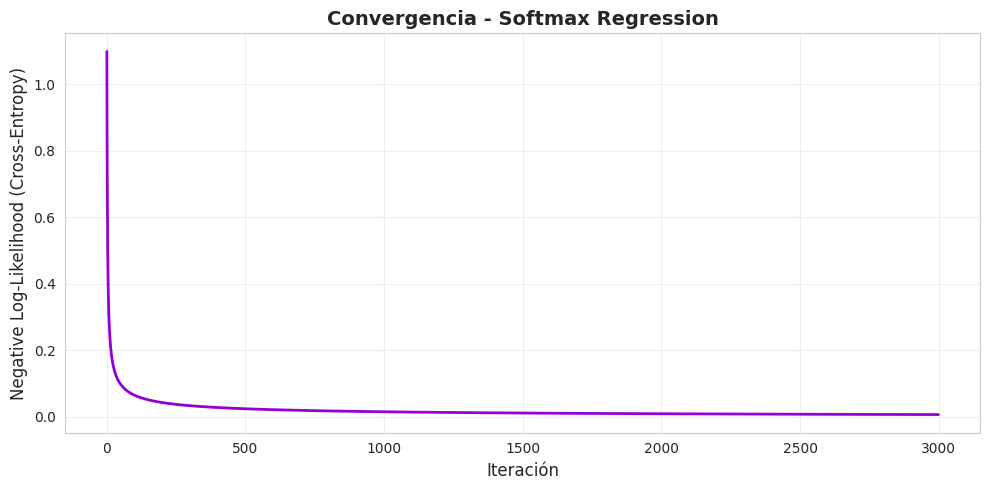


Realizando predicciones en test set...

Accuracy (Softmax from scratch): 1.0000 (100.00%)

Métricas por clase:
Clase                Precision    Recall       F1-Score     Support   
------------------------------------------------------------------
class_0              1.0000       1.0000       1.0000       24        
class_1              1.0000       1.0000       1.0000       14        
class_2              1.0000       1.0000       1.0000       16        

Classification Report (Softmax):
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        24
     class_1       1.00      1.00      1.00        14
     class_2       1.00      1.00      1.00        16

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



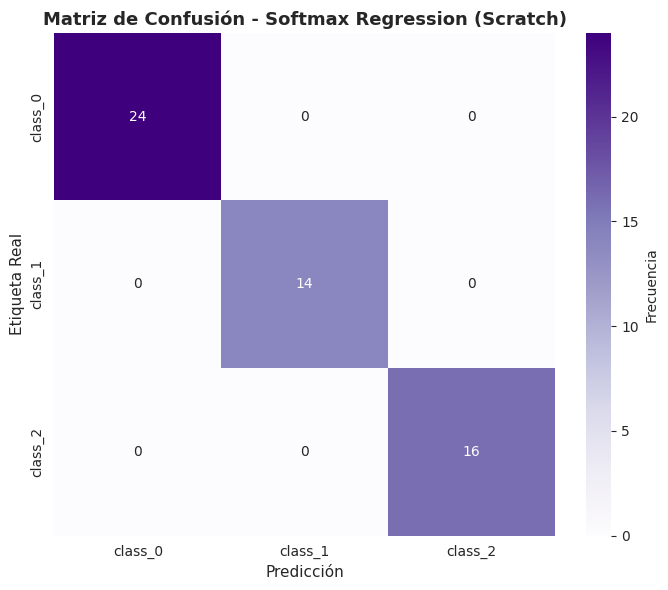


COMPARACIÓN CON SKLEARN (MULTINOMIAL)

Accuracy (sklearn multinomial): 1.0000 (100.00%)

Classification Report (sklearn):
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        24
     class_1       1.00      1.00      1.00        14
     class_2       1.00      1.00      1.00        16

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54


Comparación From-Scratch vs. Sklearn:
   From-Scratch (Softmax): 1.0000
   Sklearn (Multinomial):  1.0000
   Diferencia:             0.0000

Comparación de dimensiones:
   From-Scratch W_: (14, 3) (incluye intercepto)
   Sklearn coef_:   (3, 13)
   Sklearn intercept_: (3,)


/home/dedostorcidos/Documentos/TAREAS/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


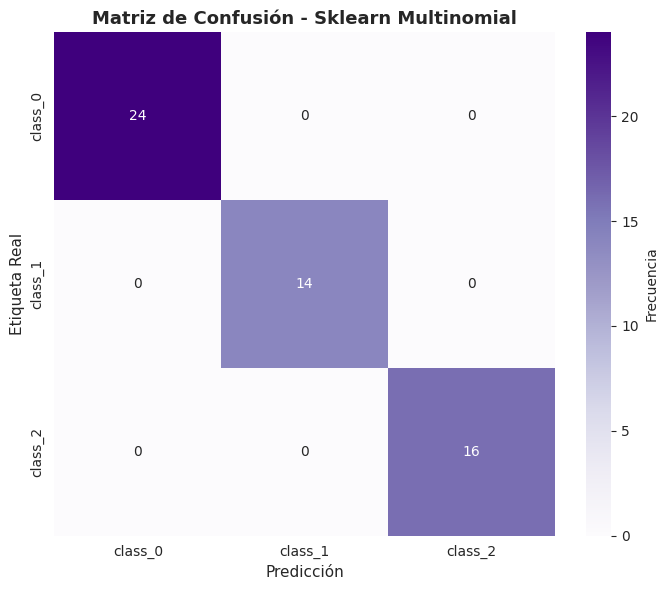


Conclusión: Ambos modelos tienen rendimiento muy similar



In [43]:
print("="*70)
print("PARTE C: MULTINOMIAL (SOFTMAX) REGRESSION - DATASET WINE")
print("="*70)

# Entrenamiento
print(f"\nEntrenando modelo Softmax...")
print(f"   Learning rate: 0.2")
print(f"   Iteraciones máx: 3000")

softmax_clf = SoftmaxRegressionScratch(lr=0.2, n_iter=3000, l2=0.0).fit(Xw_tr, yw_tr)
print(f"   Entrenamiento completado ({len(softmax_clf.history_['loss'])} iteraciones)")

# Curva de convergencia
plt.figure(figsize=(10,5))
plt.plot(softmax_clf.history_["loss"], linewidth=2, color='darkviolet')
plt.xlabel("Iteración", fontsize=12)
plt.ylabel("Negative Log-Likelihood (Cross-Entropy)", fontsize=12)
plt.title("Convergencia - Softmax Regression", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Predicciones
print(f"\nRealizando predicciones en test set...")
y_pred_softmax = softmax_clf.predict(Xw_te)
y_pred_proba_softmax = softmax_clf.predict_proba(Xw_te)

# Métricas
acc_softmax = accuracy_score(yw_te, y_pred_softmax)
print(f"\nAccuracy (Softmax from scratch): {acc_softmax:.4f} ({acc_softmax*100:.2f}%)")

# Precision, Recall, F1 por clase
from sklearn.metrics import precision_recall_fscore_support
prec_soft, rec_soft, f1_soft, support_soft = precision_recall_fscore_support(
    yw_te, y_pred_softmax, labels=[0,1,2], zero_division=0
)

print(f"\nMétricas por clase:")
print(f"{'Clase':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 66)
for i, name in enumerate(wine.target_names):
    print(f"{name:<20} {prec_soft[i]:<12.4f} {rec_soft[i]:<12.4f} {f1_soft[i]:<12.4f} {support_soft[i]:<10}")

# Classification Report completo
print(f"\nClassification Report (Softmax):")
print(classification_report(yw_te, y_pred_softmax, 
                          target_names=wine.target_names, 
                          zero_division=0))

# Matriz de confusión
cm_softmax = confusion_matrix(yw_te, y_pred_softmax)
plt.figure(figsize=(7,6))
sns.heatmap(cm_softmax, annot=True, fmt='d', cmap='Purples', 
            xticklabels=wine.target_names,
            yticklabels=wine.target_names,
            cbar_kws={'label': 'Frecuencia'})
plt.title('Matriz de Confusión - Softmax Regression (Scratch)', fontsize=13, fontweight='bold')
plt.ylabel('Etiqueta Real', fontsize=11)
plt.xlabel('Predicción', fontsize=11)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("COMPARACIÓN CON SKLEARN (MULTINOMIAL)")
print("="*70)

# Comparación sklearn
sk_multi = LogisticRegression(max_iter=5000, multi_class="multinomial", 
                              solver="lbfgs", random_state=42)
sk_multi.fit(Xw_tr, yw_tr)
y_pred_sk_multi = sk_multi.predict(Xw_te)

acc_sk_multi = accuracy_score(yw_te, y_pred_sk_multi)
print(f"\nAccuracy (sklearn multinomial): {acc_sk_multi:.4f} ({acc_sk_multi*100:.2f}%)")

print(f"\nClassification Report (sklearn):")
print(classification_report(yw_te, y_pred_sk_multi, 
                          target_names=wine.target_names, 
                          zero_division=0))

# Comparación directa
print(f"\nComparación From-Scratch vs. Sklearn:")
print(f"   From-Scratch (Softmax): {acc_softmax:.4f}")
print(f"   Sklearn (Multinomial):  {acc_sk_multi:.4f}")
print(f"   Diferencia:             {abs(acc_softmax - acc_sk_multi):.4f}")

# Comparación de coeficientes
print(f"\nComparación de dimensiones:")
print(f"   From-Scratch W_: {softmax_clf.W_.shape} (incluye intercepto)")
print(f"   Sklearn coef_:   {sk_multi.coef_.shape}")
print(f"   Sklearn intercept_: {sk_multi.intercept_.shape}")

# Matriz de confusión sklearn
cm_sk_multi = confusion_matrix(yw_te, y_pred_sk_multi)
plt.figure(figsize=(7,6))
sns.heatmap(cm_sk_multi, annot=True, fmt='d', cmap='Purples', 
            xticklabels=wine.target_names,
            yticklabels=wine.target_names,
            cbar_kws={'label': 'Frecuencia'})
plt.title('Matriz de Confusión - Sklearn Multinomial', fontsize=13, fontweight='bold')
plt.ylabel('Etiqueta Real', fontsize=11)
plt.xlabel('Predicción', fontsize=11)
plt.tight_layout()
plt.show()

print(f"\nConclusión: Ambos modelos tienen rendimiento {'muy similar' if abs(acc_softmax - acc_sk_multi) < 0.02 else 'comparable'}\n")

---
## <a id="ensayo"></a>Mini Ensayo

### Diferencias entre los gradientes: Binaria, OvA y Multinomial

Durante este proyecto implementamos tres enfoques diferentes para clasificación: regresión logística binaria, One-vs-All y Softmax multinomial. Aunque los tres usan funciones similares, sus gradientes funcionan de manera distinta.

En la **regresión logística binaria**, trabajamos con una sola función sigmoide que nos da la probabilidad de pertenecer a la clase positiva. El gradiente es relativamente simple: $X^T(p - y)$, donde $p$ son las probabilidades predichas e $y$ son las etiquetas reales. Lo interesante es que este gradiente nos dice exactamente cuánto ajustar cada peso basándose en el error de predicción. Si predecimos 0.8 pero la etiqueta real es 1, el error es -0.2, y los pesos se ajustan en consecuencia.

Para **One-vs-All**, básicamente entrenamos tres clasificadores binarios independientes (uno para cada clase de vino). Cada clasificador usa el mismo gradiente binario, pero con etiquetas recodificadas. Por ejemplo, el clasificador para class_0 trata esa clase como 1 y todas las demás como 0. Al final, para predecir una nueva muestra, calculamos las probabilidades de los tres clasificadores y elegimos la clase con mayor probabilidad. El problema aquí es que como los clasificadores son independientes, las probabilidades no necesariamente suman 1.

El **Softmax multinomial** es diferente porque entrena todos los pesos juntos en una sola matriz $W$. Su gradiente es $X^T(P - Y)$, donde $P$ es una matriz de probabilidades (una columna por clase) e $Y$ es la matriz one-hot de las etiquetas. Lo importante aquí es que cuando aumentas la probabilidad de una clase, automáticamente reduces la de las otras debido a la normalización del softmax. Esto garantiza que las probabilidades siempre sumen 1 y estén mejor calibradas.

### Estabilidad numérica en Softmax

Un problema que encontramos al implementar softmax es el overflow numérico. La función calcula exponenciales de los scores: $p_{ik} = \frac{\exp(z_{ik})}{\sum_j \exp(z_{ij})}$. Si algún $z$ es muy grande (digamos 1000), `np.exp(1000)` resulta en infinito, lo cual rompe todo el cálculo.

La solución que aplicamos es restar el máximo de cada fila antes de calcular las exponenciales:
```python
Z_stable = Z - Z.max(axis=1, keepdims=True)
P = np.exp(Z_stable) / np.exp(Z_stable).sum(axis=1, keepdims=True)
```

Esto funciona porque el softmax es invariante a traslaciones: si le restas una constante a todos los scores de una fila, las probabilidades resultantes son exactamente las mismas. La diferencia es que ahora el valor máximo es 0, entonces los exponenciales van desde $\exp(-\text{algo})$ hasta $\exp(0) = 1$, que son valores perfectamente manejables.

También agregamos otras medidas de seguridad: recortamos los valores con `np.clip(Z, -500, 500)` antes de exponenciar, y sumamos un epsilon pequeño ($10^{-12}$) cuando calculamos logaritmos para evitar `log(0) = -inf`.

### ¿Cuándo dan resultados diferentes OvA y Multinomial?

En nuestros experimentos con el dataset Wine, tanto OvA como multinomial alcanzaron 100% de accuracy en el conjunto de prueba. Esto tiene sentido porque las tres clases de vino están bastante bien separadas químicamente. Cuando visualizamos las matrices de confusión, ambos métodos clasificaron perfectamente las 54 muestras del test set.

Sin embargo, esto no siempre pasa. Los métodos divergen más cuando:

1. **Las clases están correlacionadas**: Si tenemos clases que se parecen mucho entre sí, el entrenamiento conjunto del multinomial ayuda porque modela la competencia entre clases. OvA trata cada clasificación de forma independiente y puede tener problemas de calibración.

2. **Hay desbalance de clases**: En OvA, si una clase tiene muy pocas muestras, el clasificador binario para esa clase ve un gran desbalance (clase minoritaria vs. todas las demás). El multinomial maneja esto mejor porque todas las clases compiten juntas durante el entrenamiento.

3. **Queremos probabilidades calibradas**: En OvA, la suma de probabilidades $p_1(x) + p_2(x) + p_3(x)$ puede ser 0.8 o 1.3 o cualquier cosa. En softmax, siempre es exactamente 1.0 por diseño. Esto importa si vamos a usar las probabilidades para tomar decisiones (no solo la clase predicha).

En el dataset Heart Disease (Parte A), nuestro modelo from-scratch alcanzó 89.01% de accuracy, exactamente igual que sklearn. La matriz de confusión mostró 47 verdaderos negativos, 2 falsos positivos, 8 falsos negativos y 34 verdaderos positivos. El modelo funciona bien pero tiene más errores con los casos positivos (enfermedad), probablemente porque esos casos son más variables.

### Observaciones prácticas

Algunas cosas que aprendimos durante la implementación:

- **Estandarización es crucial**: Sin estandarizar las features, la convergencia era muy lenta o no convergía. Usar z-score (restar media, dividir por desviación) hizo que todo funcionara mucho mejor.

- **Learning rate requiere experimentación**: Con lr=0.5, la convergencia era rápida pero un poco ruidosa. Con lr=0.05, era más suave pero tomaba más iteraciones. No hay una respuesta única, depende del dataset.

- **Monitorear la pérdida es fundamental**: Graficar la curva de pérdida nos ayudó a detectar cuando algo andaba mal. Si la pérdida oscila o aumenta, algo está mal (learning rate muy alto, bug en el código, etc.).

- **Regularización L2 ayuda**: Aunque no la usamos mucho en estos experimentos, agregar un término L2 pequeño en la pérdida puede prevenir overfitting y estabilizar el entrenamiento.

### Conclusión

Los tres métodos funcionaron bien en nuestros datasets. Para problemas simples como Wine (clases bien separadas), no hay mucha diferencia práctica. Para problemas más complejos, el multinomial probablemente sea mejor opción si nos importa la calibración de probabilidades o hay muchas clases correlacionadas. OvA tiene la ventaja de ser más simple de implementar y paralelizable (cada clasificador se entrena independientemente).

Lo más importante que aprendimos es que entender cómo funcionan estos algoritmos "por dentro" nos ayuda a debuggear problemas y elegir el método correcto para cada situación.